In [311]:
# importing packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error,mean_absolute_error
import datetime 
import os
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
# from pyramid.arima import auto_arima
print(os.listdir("../input"))

['round2', 'round2csv']


In [312]:
# Function to load data
def load_data(debug=False):
    if debug:
        nrows = 10000
    else:
        nrows = None
    print('Loading data')
    df = pd.read_csv('../input/round2csv/hackathon_data_round2.csv',nrows=nrows)
    df.rename(columns={'Donation_Date ':'Date','Financial_Year ':'Financial_Year'},inplace=True)
    return df

In [276]:
def preprocessing(df):
    print('Preprocessing')
    df['Date'] = pd.to_datetime(df['Date']) #converting to datetime object
    df['to_drop'] = df['Date'].dt.year.apply(lambda x:1 if x not in [2013,2014,2015,2016,2017,2018,2019] else 0) 
    df.drop(df[df['to_drop']==1].index,axis=0,inplace=True) #dropping dates where year not in 2013,2014,2015,2016,2017,2018,2019
    
    #printing maximum and minimum dates
    print('Minimum date in in data is {}'.format(min(df['Date'])))
    print('Maximum date in in data is {}'.format(max(df['Date'])))
    
    df.sort_values('Date',inplace=True)
    df['Weeks'] = ((datetime.datetime.today() - df['Date']).dt.days)//7
    
    # declaring a binary variable Is_Bad which will be 1 if donor is failed in any of the test
    mask = (df['C1']=='R') | (df['C1']=='P') | (df['C2']=='R') | (df['C2']=='P')|(df['Test_3']=='R') | (df['Test_3']=='P') | (df['Test_4']=='R') | (df['Test_4']=='P')
    df['Is_Bad'] = np.where(mask,1,0)
    
    return df

In [277]:
def features_TS(df):
    # Creating binary variables for most repeated Blood groups  
    df['Blood_Group_Code_1'] = df['Blood_Group_Code'].apply(lambda x:1 if x==1 else 0)
    df['Blood_Group_Code_3'] = df['Blood_Group_Code'].apply(lambda x:1 if x==3 else 0)
    df['Blood_Group_Code_5'] = df['Blood_Group_Code'].apply(lambda x:1 if x==5 else 0)
    df['Blood_Group_Code_7'] = df['Blood_Group_Code'].apply(lambda x:1 if x==7 else 0)
    return df

In [313]:
# function for the Arima model for time forecasting
def model(group,col):
    X = group.values
    size = int(len(X) * 0.8)
    size_end = int(len(X)*0.9)
    train, test = X[0:size], X[size:size_end]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
#         print('predicted=%f, expected=%f' % (yhat, obs))
#     error = mean_squared_error(test, predictions)
    error = mean_absolute_error(test, predictions)
    print('Test Mean Absolute Error for {}  = {}'.format(col,error))
#     # plot
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.title(col,fontsize=20)
    plt.savefig('{}.png'.format(col))
    plt.show()

In [280]:
# Calling our functions
df = load_data(debug=0)
df = preprocessing(df) #Apply preprocessing steps
df =features_TS(df)# Creating featiures for timeseries forecasting

Loading data
Preprocessing
Minimum date in in data is 2013-01-22 00:00:00
Maximum date in in data is 2018-07-06 00:00:00


# Analysis

In [314]:
labels = df['Branch_Code '].value_counts().index
sizes = df['Branch_Code '].value_counts().values

fig = {
  "data": [
    {
      "values": sizes,
      "labels": labels,
      "domain": {"x": [0, .48]},
      "name": "Branch",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Number Of Donors Per Branch",
        "annotations": [
            {
                "font": {
                    "size": 30
                },
                "showarrow": False,
                "text": "Branch",
                "x": 0.17,
                "y": 0.5
            } ]}}
py.iplot(fig, filename='donut')


In [315]:
labels = df['Donation_type '].value_counts().index
sizes = df['Donation_type '].value_counts().values

fig = {
  "data": [
    {
      "values": sizes,
      "labels": labels,
      "domain": {"x": [0, .48]},
      "name": "Donation Type",
      "hoverinfo":"label+percent+name",
      "hole": .4,
      "type": "pie"
    }],
  "layout": {
        "title":"Number Of Donation Types",
#         "annotations": [
#             {
#                 "font": {
#                     "size": 30
#                 },
#                 "showarrow": False,
#                 "text": "Donation",
#                 "x": 0.17,
#                 "y": 0.5
#             } ]
  }}
py.iplot(fig, filename='donut')


Text(0.5, 1.0, 'Donor Age VS Probabilty Of Being An Infectious Donor')

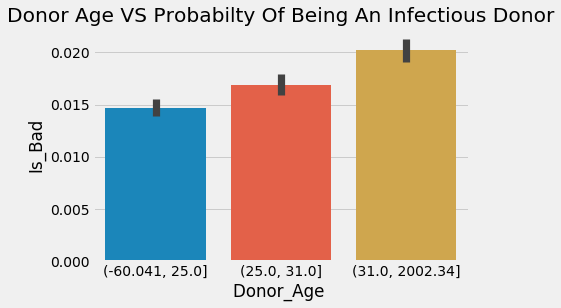

In [318]:
sns.barplot(pd.qcut(df['Donor_Age '],3),df['Is_Bad'])
plt.title('Donor Age VS Probabilty Of Being An Infectious Donor')

# Time Series Forecasting

Test Mean Absolute Error for Number of Customers Per Week  = 75.86400562179088


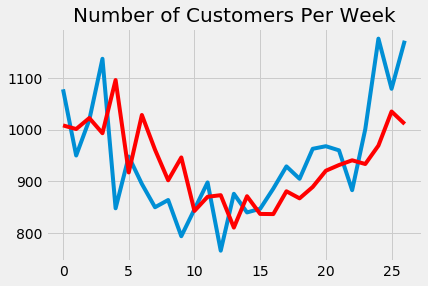

Test Mean Absolute Error for Number of Infectious Customers Per Week  = 3.8697560761427496


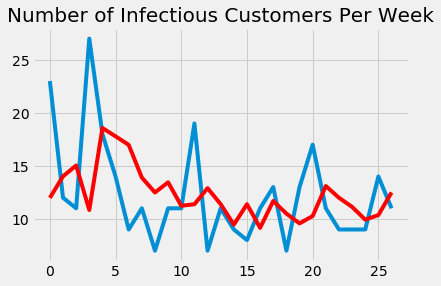

In [307]:
# Grouping by Week and applying ARIMA to predict number of donors per week
group = df.groupby('Weeks').size()
model(group,'Number of Customers Per Week')

# Grouping by Week and applying ARIMA to predict number of infectious donors per week
group = df.groupby('Weeks')['Is_Bad'].sum()
model(group,'Number of Infectious Customers Per Week')


Test Mean Absolute Error for Number Of Blood_Group_Code 1 Per Week  = 22.55520726363548


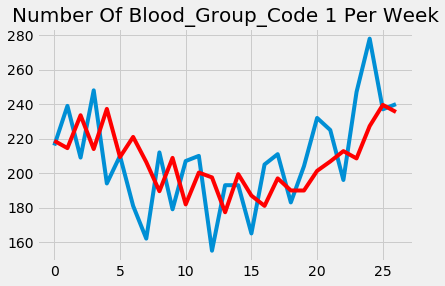

Test Mean Absolute Error for Number Of Blood_Group_Code 3 Per Week  = 35.750294404908104


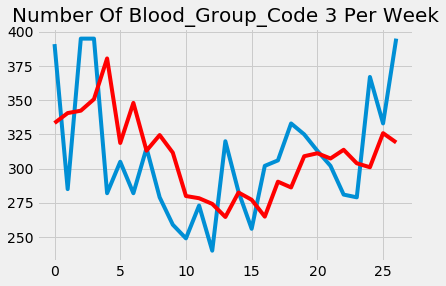

In [300]:
# Grouping by Week and applying ARIMA to predict number of customers having Blood_Group_Code = 1 per week
group = df.groupby('Weeks')['Blood_Group_Code_1'].sum()
model(group,'Number Of Blood_Group_Code 1 Per Week')

# Grouping by Week and applying ARIMA to predict number of customers having Blood_Group_Code = 3 per week
group = df.groupby('Weeks')['Blood_Group_Code_3'].sum()
model(group,'Number Of Blood_Group_Code 3 Per Week')


Test Mean Absolute Error for Number Of Blood_Group_Code 5 Per Week  = 28.454275762710054


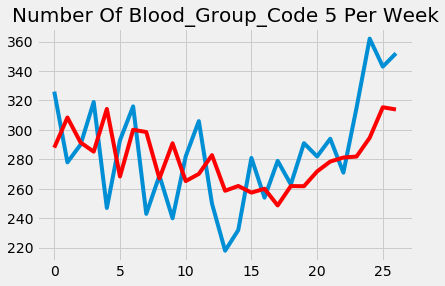

Test Mean Absolute Error for Number Of Blood_Group_Code 7 Per Week  = 11.044591431311792


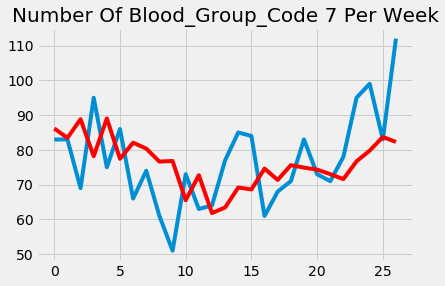

In [301]:
# Grouping by Week and applying ARIMA to predict number of customers having Blood_Group_Code = 5 per week
group = df.groupby('Weeks')['Blood_Group_Code_5'].sum()
model(group,'Number Of Blood_Group_Code 5 Per Week')

# Grouping by Week and applying ARIMA to predict number of customers having Blood_Group_Code = 7 per week
group = df.groupby('Weeks')['Blood_Group_Code_7'].sum()
model(group,'Number Of Blood_Group_Code 7 Per Week')
